In [1]:
#Imports librairies 
import pandas as pd
import duckdb
import yaml

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Chargemnt des 3 fichiers Excel
erp = pd.read_excel('../data_bottleneck/erp.xlsx')
liaison = pd.read_excel('../data_bottleneck/liaison.xlsx')
web = pd.read_excel('../data_bottleneck/web.xlsx')

print("Fichiers chargés ✅")

/Users/axellerolain/Desktop/P10 - mise en place pipeline orchestration de flux/venv/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/axellerolain/Desktop/P10 - mise en place pipeline orchestration de flux/venv/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/axellerolain/Desktop/P10 - mise en place pipeline orchestration de flux/venv/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Fichiers chargés ✅


In [3]:
# Chargemnt de la config de test
with open('../config/test_config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
print("Configuration chargée ✅")
print(config)

Configuration chargée ✅
{'nettoyage': {'erp_apres_dedoublonnage': 825, 'liaison_apres_dedoublonnage': 825, 'web_apres_nettoyage': 1428, 'web_apres_dedoublonnage': 714}, 'fusion': {'lignes_finales': 714}, 'calculs': {'ca_total': 70568.6, 'tolerance_ca': 0.01}, 'identification': {'vins_premium': 30, 'zscore_seuil': 2}}


## Exploration fichiers

In [4]:
# Exploration ERP
print("=== FICHIER ERP ===")
print(f"Dimensions: {erp.shape}")
print(f"\nColonnes: {erp.columns.tolist()}")
print(f"\nPremières lignes:")
erp.head()

=== FICHIER ERP ===
Dimensions: (825, 5)

Colonnes: ['product_id', 'onsale_web', 'price', 'stock_quantity', 'stock_status']

Premières lignes:


,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


In [5]:
# Exploration LIAISON
print("=== FICHIER LIAISON ===")
print(f"Dimensions: {liaison.shape}")
print(f"\nColonnes: {liaison.columns.tolist()}")
print(f"\nPremières lignes:")
liaison.head()

=== FICHIER LIAISON ===
Dimensions: (825, 2)

Colonnes: ['product_id', 'id_web']

Premières lignes:


,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815


In [6]:
# Exploration WEB
print("=== FICHIER WEB ===")
print(f"Dimensions: {web.shape}")
print(f"\nColonnes: {web.columns.tolist()}")
print(f"\nPremières lignes:")
web.head(3)

=== FICHIER WEB ===
Dimensions: (1513, 28)

Colonnes: ['sku', 'virtual', 'downloadable', 'rating_count', 'average_rating', 'total_sales', 'tax_status', 'tax_class', 'post_author', 'post_date', 'post_date_gmt', 'post_content', 'post_title', 'post_excerpt', 'post_status', 'comment_status', 'ping_status', 'post_password', 'post_name', 'post_modified', 'post_modified_gmt', 'post_content_filtered', 'post_parent', 'guid', 'menu_order', 'post_type', 'post_mime_type', 'comment_count']

Premières lignes:


,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,16004,0,0,0,0.0,5.0,NaN,NaN,2.0,2018-06-07 16:27:25,...,chateau-du-couvent-pomerol-2017,2020-08-25 18:35:02,2020-08-25 16:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15075,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-14 15:39:43,...,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [7]:
# Check des doublons dans ERP
print("=== DOUBLONS ERP ===")
print(f"Nombre de lignes total : {len(erp)}")
print(f"Nombre de product_id uniques : {erp['product_id'].nunique()}")
print(f"Doublons détectés : {len(erp) - erp['product_id'].nunique()}")

=== DOUBLONS ERP ===
Nombre de lignes total : 825
Nombre de product_id uniques : 825
Doublons détectés : 0


In [8]:
# Check des doublons dans LIAISON
print("=== DOUBLONS LIAISON ===")
print(f"Nombre de lignes total : {len(liaison)}")
print(f"Nombre de product_id uniques : {liaison['product_id'].nunique()}")
print(f"Nombre de id_web uniques : {liaison['id_web'].nunique()}")

=== DOUBLONS LIAISON ===
Nombre de lignes total : 825
Nombre de product_id uniques : 825
Nombre de id_web uniques : 734


**donc 91 id_web en doublon ou manquants**

In [9]:
# Check des doublons et valeurs manquantes dans WEB
print("=== ANALYSE WEB ===")
print(f"Nombre de lignes total : {len(web)}")
print(f"Nombre de sku uniques : {web['sku'].nunique()}")
print(f"\nValeurs manquantes par colonne :")
print(web.isnull().sum())
print(f"\nDoublons sur sku : {len(web) - web['sku'].nunique()}")

=== ANALYSE WEB ===
Nombre de lignes total : 1513
Nombre de sku uniques : 714

Valeurs manquantes par colonne :
sku                        85
virtual                     0
downloadable                0
rating_count                0
average_rating             83
total_sales                83
tax_status                797
tax_class                1513
post_author                83
post_date                  83
post_date_gmt              83
post_content             1513
post_title                 83
post_excerpt              797
post_status                83
comment_status             83
ping_status                83
post_password            1513
post_name                  83
post_modified              83
post_modified_gmt          83
post_content_filtered    1513
post_parent                83
guid                       83
menu_order                 83
post_type                  83
post_mime_type            799
comment_count              83
dtype: int64

Doublons sur sku : 799


In [10]:
# Check ERP et LIAISON (pas de nettoyage normalement... Même chiffre que Stéphane)
print("=== VÉRIFICATION ERP ===")
assert len(erp) == config['nettoyage']['erp_apres_dedoublonnage'], "❌ Erreur ERP"
print(f"✅ ERP OK : {len(erp)} lignes")

print("\n=== VÉRIFICATION LIAISON ===")
assert len(liaison) == config['nettoyage']['liaison_apres_dedoublonnage'], "❌ Erreur LIAISON"
print(f"✅ LIAISON OK : {len(liaison)} lignes")

=== VÉRIFICATION ERP ===
✅ ERP OK : 825 lignes

=== VÉRIFICATION LIAISON ===
✅ LIAISON OK : 825 lignes


In [11]:
# Nettoyage WEB
print("=== NETTOYAGE WEB ===")

# Suppress des valeurs manquantes sur sku
web_clean = web.dropna(subset=['sku'])
print(f"Après suppression valeurs manquantes : {len(web_clean)} lignes")
print(f"Attendu : {config['nettoyage']['web_apres_nettoyage']}") #check chiffre Stephane 


# Cellule : Dédoublonnage en gardant le MAX de total_sales
print("=== DÉDOUBLONNAGE - STRATÉGIE MAX NBRE VENTES ===")

# Trier par total_sales décroissant, puis drop_duplicates garde le premier (= le max)
web_dedup = web_clean.sort_values('total_sales', ascending=False).drop_duplicates(subset=['sku'], keep='first')

print(f"Lignes après dédoublonnage : {len(web_dedup)}")
print(f"Attendu : {config['nettoyage']['web_apres_dedoublonnage']}")

# Check final
assert len(web_clean) == config['nettoyage']['web_apres_nettoyage'], "❌ Erreur nettoyage"
assert len(web_dedup) == config['nettoyage']['web_apres_dedoublonnage'], "❌ Erreur dédoublonnage"
print("✅ Tests OK !")

=== NETTOYAGE WEB ===
Après suppression valeurs manquantes : 1428 lignes
Attendu : 1428
=== DÉDOUBLONNAGE - STRATÉGIE MAX NBRE VENTES ===
Lignes après dédoublonnage : 714
Attendu : 714
✅ Tests OK !


# Fusion fichiers

In [12]:
# Fusion ERP + LIAISON
print("=== FUSION ERP + LIAISON ===")

# Inner joint sur product_id entre erp et liaison 
erp_liaison = erp.merge(liaison, on='product_id', how='inner') #Création du nouveau dataframe erp_liaison 

print(f"Lignes après fusion : {len(erp_liaison)}")
print(f"Colonnes : {erp_liaison.columns.tolist()}")
erp_liaison.head()

=== FUSION ERP + LIAISON ===
Lignes après fusion : 825
Colonnes : ['product_id', 'onsale_web', 'price', 'stock_quantity', 'stock_status', 'id_web']


,product_id,onsale_web,price,stock_quantity,stock_status,id_web
0,3847,1,24.2,0,outofstock,15298
1,3849,1,34.3,0,outofstock,15296
2,3850,1,20.8,0,outofstock,15300
3,4032,1,14.1,0,outofstock,19814
4,4039,1,46.0,0,outofstock,19815


In [13]:
# Check nbre de lignes attendu 
print("=== VÉRIFICATION VALEURS MANQUANTES AVANT JOIN===")

print("\nDans ERP_LIAISON :")
print(erp_liaison[['product_id', 'price', 'id_web']].isnull().sum())

print("\nDans WEB_DEDUP :")
print(web_dedup[['sku', 'total_sales']].isnull().sum())

=== VÉRIFICATION VALEURS MANQUANTES AVANT JOIN===

Dans ERP_LIAISON :
product_id     0
price          0
id_web        91
dtype: int64

Dans WEB_DEDUP :
sku            0
total_sales    0
dtype: int64


In [14]:
# Fusion LIAISON avec WEB (via id_web = sku)
print("=== FUSION ERP_LIAISON AVEC WEB ===")

# Inner jointure sur id_web (liaison) = sku (web) 
# Création du dataframe final data_finale 
data_finale = erp_liaison.merge(
    web_dedup, 
    left_on='id_web', 
    right_on='sku', 
    how='inner'
)

print(f"Lignes finales : {len(data_finale)}")
print(f"Attendu : {config['fusion']['lignes_finales']}")

# Test
assert len(data_finale) == config['fusion']['lignes_finales'], "❌ Erreur fusion"
print("✅ Test fusion OK !")

print(f"\nColonnes disponibles : {data_finale.columns.tolist()}")

=== FUSION ERP_LIAISON AVEC WEB ===
Lignes finales : 714
Attendu : 714
✅ Test fusion OK !

Colonnes disponibles : ['product_id', 'onsale_web', 'price', 'stock_quantity', 'stock_status', 'id_web', 'sku', 'virtual', 'downloadable', 'rating_count', 'average_rating', 'total_sales', 'tax_status', 'tax_class', 'post_author', 'post_date', 'post_date_gmt', 'post_content', 'post_title', 'post_excerpt', 'post_status', 'comment_status', 'ping_status', 'post_password', 'post_name', 'post_modified', 'post_modified_gmt', 'post_content_filtered', 'post_parent', 'guid', 'menu_order', 'post_type', 'post_mime_type', 'comment_count']


## Calcul CA

In [15]:
# Exploration des colonnes importantes pour le CA
print("=== COLONNES CLÉS POUR LE CA ===")

colonnes_importantes = ['product_id', 'price', 'total_sales', 'post_title']
print(data_finale[colonnes_importantes].head(10))

print(f"\nStatistiques sur price :")
print(data_finale['price'].describe())

print(f"\nStatistiques sur total_sales :")
print(data_finale['total_sales'].describe())

=== COLONNES CLÉS POUR LE CA ===
   product_id  price  total_sales  \
0        3847   24.2          6.0   
1        3849   34.3          0.0   
2        3850   20.8          0.0   
3        4032   14.1          3.0   
4        4039   46.0          0.0   
5        4040   34.3          0.0   
6        4041   32.7          0.0   
7        4042   31.2          7.0   
8        4043   60.0          3.0   
9        4045   42.6         14.0   

                                          post_title  
0        Pierre Jean Villa Saint-Joseph Préface 2018  
1    Pierre Jean Villa Saint-Joseph Rouge Tildé 2017  
2  Pierre Jean Villa Crozes-Hermitage Accroche Co...  
3  Pierre Jean Villa IGP Collines Rhodaniennes Ga...  
4          Pierre Jean Villa Côte Rôtie Carmina 2017  
5  Pierre Jean Villa Saint-Joseph Saut De l'Ange ...  
6                      Pierre Gaillard Condrieu 2018  
7                        Pierre Gaillard Cornas 2017  
8   Pierre Gaillard Côte Rôtie Esprit de Blonde 2017  
9        

In [16]:
# Calcul du CA
print("=== CALCUL DU CHIFFRE D'AFFAIRES ===")

# CA = price × total_sales
data_finale['ca'] = data_finale['price'] * data_finale['total_sales']

# CA total
ca_total = data_finale['ca'].sum()
print(f"\n💰 Chiffre d'affaires total : {ca_total:.2f} €")
print(f"Attendu : {config['calculs']['ca_total']} €")


=== CALCUL DU CHIFFRE D'AFFAIRES ===

💰 Chiffre d'affaires total : 70568.60 €
Attendu : 70568.6 €


In [17]:
# Affichage du CA par produit (top 10) 
print("CA par produit (top 10) :")
display(data_finale[['product_id', 'post_title', 'price', 'total_sales', 'ca']].sort_values('ca', ascending=False).head(10))

CA par produit (top 10) :


,product_id,post_title,price,total_sales,ca
194,4334,Champagne Gosset Grand Blanc de Blancs,49.0,96.0,4704.0
71,4144,Champagne Gosset Grand Rosé,49.0,87.0,4263.0
218,4402,Cognac Frapin VIP XO,176.0,13.0,2288.0
70,4142,Champagne Gosset Grand Millésime 2006,53.0,30.0,1590.0
69,4141,Champagne Gosset Grande Réserve,39.0,40.0,1560.0
201,4355,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5,11.0,1391.5
199,4352,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,5.0,1125.0
79,4153,Elian Daros Côtes du Marmandais Clos Baquey 2015,29.0,36.0,1044.0
651,6206,Domaine Giudicelli Patrimonio Blanc 2019,25.2,41.0,1033.2
30,4068,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,16.6,62.0,1029.2


In [18]:
# Test
tolerance = config['calculs']['tolerance_ca']
assert abs(ca_total - config['calculs']['ca_total']) < tolerance, "❌ Erreur CA total"
print("✅ Test CA total OK !")

✅ Test CA total OK !


## Identification des vins premium avec le Z score

In [19]:
# Calcul du z-score
print("=== IDENTIFICATION VINS PREMIUM ===")

# Calculer le z-score sur les prix
prix_moyen = data_finale['price'].mean()
prix_std = data_finale['price'].std()

data_finale['z_score'] = (data_finale['price'] - prix_moyen) / prix_std

print(f"Prix moyen : {prix_moyen:.2f} €")
print(f"Écart-type : {prix_std:.2f} €")
print(f"Seuil z-score : {config['identification']['zscore_seuil']}")


=== IDENTIFICATION VINS PREMIUM ===
Prix moyen : 32.49 €
Écart-type : 27.81 €
Seuil z-score : 2


In [20]:
# Identifier les vins premium (z-score > 2)
vins_premium = data_finale[data_finale['z_score'] > config['identification']['zscore_seuil']]
vins_ordinaires = data_finale[data_finale['z_score'] <= config['identification']['zscore_seuil']]

print(f"\n🍷 Vins premium : {len(vins_premium)}")
print(f"Attendu : {config['identification']['vins_premium']}")

print(f"🍷 Vins ordinaires : {len(vins_ordinaires)}")




🍷 Vins premium : 30
Attendu : 30
🍷 Vins ordinaires : 684


In [21]:
# Test
assert len(vins_premium) == config['identification']['vins_premium'], "❌ Erreur vins premium"
print("✅ Test vins premium OK !")



✅ Test vins premium OK !


In [22]:
# Afficher les 10 vins les plus chers
print("\nTop 10 vins premium (z-score le plus élevé) :")
print(vins_premium[['post_title', 'price', 'z_score']].sort_values('z_score', ascending=False).head(10))


Top 10 vins premium (z-score le plus élevé) :
                                            post_title  price   z_score
199     Champagne Egly-Ouriet Grand Cru Millésimé 2008  225.0  6.922087
426     David Duband Charmes-Chambertin Grand Cru 2014  217.5  6.652405
587  Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...  191.3  5.710315
218                               Cognac Frapin VIP XO  176.0  5.160164
553                Camille Giroud Clos de Vougeot 2016  175.0  5.124206
221  Cognac Frapin Château de Fontpinot 1989 20 Ans...  157.0  4.476969
381  Domaine Des Croix Corton Charlemagne Grand Cru...  137.0  3.757817
642             Champagne Gosset Célébris Vintage 2007  135.0  3.685902
201     Champagne Egly-Ouriet Grand Cru Blanc de Noirs  126.5  3.380262
511  Domaine Weinbach Gewurztraminer Grand Cru Furs...  124.8  3.319134


### Visualisations des prix

=== VISUALISATION DES PRIX ===


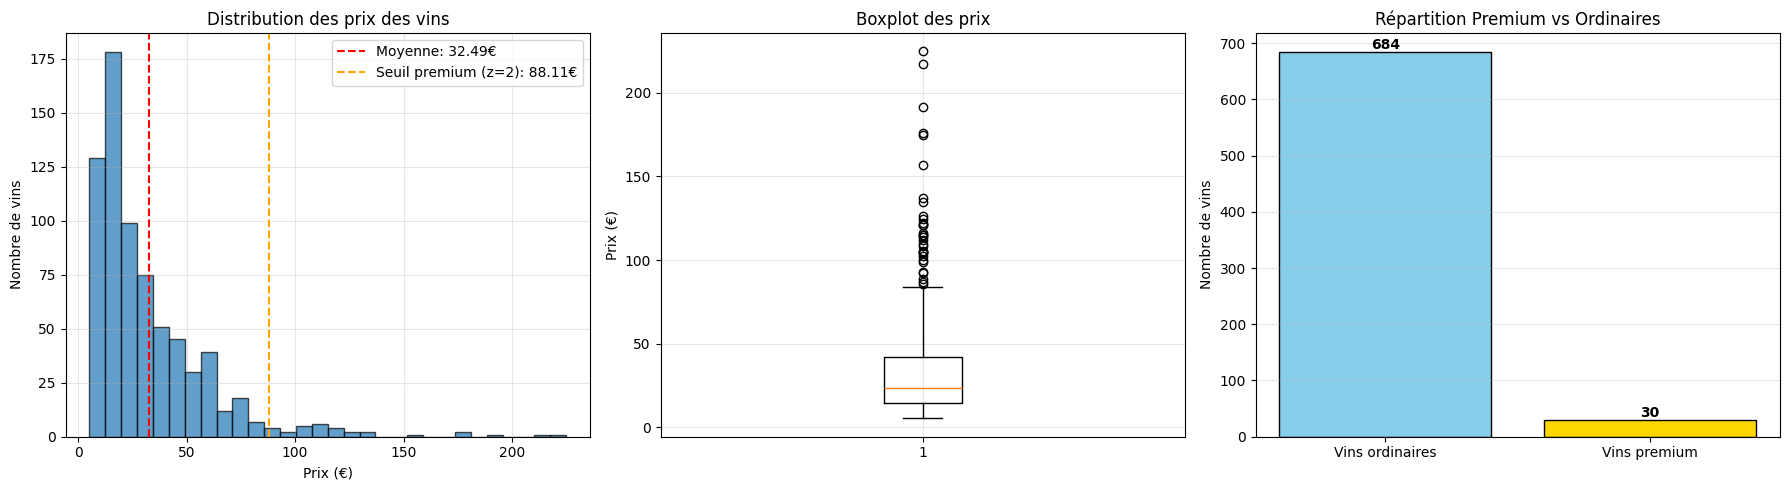

In [23]:
print("=== VISUALISATION DES PRIX ===")

# Créer une figure avec 3 graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Histogramme de la distribution des prix
axes[0].hist(data_finale['price'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(prix_moyen, color='red', linestyle='--', label=f'Moyenne: {prix_moyen:.2f}€')
axes[0].axvline(prix_moyen + 2*prix_std, color='orange', linestyle='--', label=f'Seuil premium (z=2): {prix_moyen + 2*prix_std:.2f}€')
axes[0].set_xlabel('Prix (€)')
axes[0].set_ylabel('Nombre de vins')
axes[0].set_title('Distribution des prix des vins')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Boxplot
axes[1].boxplot(data_finale['price'], vert=True)
axes[1].set_ylabel('Prix (€)')
axes[1].set_title('Boxplot des prix')
axes[1].grid(True, alpha=0.3)

# 3. Comparaison Premium vs Ordinaires
categories = ['Vins ordinaires', 'Vins premium']
counts = [len(vins_ordinaires), len(vins_premium)]
colors = ['skyblue', 'gold']
axes[2].bar(categories, counts, color=colors, edgecolor='black')
axes[2].set_ylabel('Nombre de vins')
axes[2].set_title('Répartition Premium vs Ordinaires')
axes[2].grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for i, v in enumerate(counts):
    axes[2].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [24]:
print(f"\n📊 Statistiques :")
print(f"   - Prix moyen : {prix_moyen:.2f}€")
print(f"   - Prix médian : {data_finale['price'].median():.2f}€")
print(f"   - Écart-type : {prix_std:.2f}€")
print(f"   - Prix minimum : {data_finale['price'].min():.2f}€")
print(f"   - Prix maximum : {data_finale['price'].max():.2f}€")
print(f"   - Seuil premium (z=2) : {prix_moyen + 2*prix_std:.2f}€")


📊 Statistiques :
   - Prix moyen : 32.49€
   - Prix médian : 23.55€
   - Écart-type : 27.81€
   - Prix minimum : 5.20€
   - Prix maximum : 225.00€
   - Seuil premium (z=2) : 88.11€


### Création des exports

In [25]:
# Exports des fichiers
print("=== CRÉATION DES EXPORTS ===")

# 1. Rapport CA en Excel
rapport_ca = data_finale[['product_id', 'post_title', 'price', 'total_sales', 'ca']].copy()
rapport_ca = rapport_ca.sort_values('ca', ascending=False)

# Ajouter une ligne pour le CA total
ca_total_row = {
    'product_id': 'TOTAL',
    'post_title': 'Chiffre d\'affaires total',
    'price': '',
    'total_sales': '',
    'ca': ca_total
}
rapport_ca = pd.concat([rapport_ca, pd.DataFrame([ca_total_row])], ignore_index=True)

# Export Excel
rapport_ca.to_excel('../outputs/rapport_ca.xlsx', index=False)
print(f"✅ Rapport CA exporté : {len(rapport_ca)-1} produits + total")

# 2. Export vins premium en CSV
vins_premium_export = vins_premium[['product_id', 'post_title', 'price', 'total_sales', 'ca', 'z_score']].copy()
vins_premium_export = vins_premium_export.sort_values('z_score', ascending=False)
vins_premium_export.to_csv('../outputs/vins_premium.csv', index=False)
print(f"✅ Vins premium exportés : {len(vins_premium_export)} vins")

# 3. Export vins ordinaires en CSV
vins_ordinaires_export = vins_ordinaires[['product_id', 'post_title', 'price', 'total_sales', 'ca', 'z_score']].copy()
vins_ordinaires_export = vins_ordinaires_export.sort_values('ca', ascending=False)
vins_ordinaires_export.to_csv('../outputs/vins_ordinaires.csv', index=False)
print(f"✅ Vins ordinaires exportés : {len(vins_ordinaires_export)} vins")

print("\n📁 Tous les fichiers sont dans le dossier 'outputs/' !")

=== CRÉATION DES EXPORTS ===
✅ Rapport CA exporté : 714 produits + total
✅ Vins premium exportés : 30 vins
✅ Vins ordinaires exportés : 684 vins

📁 Tous les fichiers sont dans le dossier 'outputs/' !
